In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.applications import VGG16
from matplotlib import pyplot as plt
import keras.callbacks
import cv2

In [3]:
# SET GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [26]:
SEED = 123
N_CLASSES = 1
IMG_SIZE = 224
BUFFER_SIZE = 1000
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
file_data = "data/data.csv"
data = pd.read_csv(file_data)
data = data.to_numpy()
data[:5]

array([['dataset/training/image_2/umm_000000.png',
        'dataset/training/gt_image_2/umm_road_000000.png'],
       ['dataset/training/image_2/umm_000001.png',
        'dataset/training/gt_image_2/umm_road_000001.png'],
       ['dataset/training/image_2/umm_000002.png',
        'dataset/training/gt_image_2/umm_road_000002.png'],
       ['dataset/training/image_2/umm_000003.png',
        'dataset/training/gt_image_2/umm_road_000003.png'],
       ['dataset/training/image_2/umm_000004.png',
        'dataset/training/gt_image_2/umm_road_000004.png']], dtype=object)

In [28]:
TRAIN_SIZE = int(0.8 * len(data))
VAL_SIZE = int(0.1 * len(data))
TEST_SIZE = int(0.1 * len(data))

In [29]:
@tf.function
def read_img(data):
    # Input image
    img = tf.io.read_file(data[0])
    img = tf.image.decode_jpeg(img)
    # Output segment
    segment = tf.io.read_file(data[1])
    segment = tf.image.decode_jpeg(segment)
    rgb_road = tf.constant([255, 0, 255], dtype=tf.uint8)
    segment = tf.reduce_all(segment == rgb_road, axis= 2)
    segment = tf.cast(segment, dtype=tf.uint8)
    segment_shape = tf.shape(segment)
    segment = tf.reshape(segment, (segment_shape[0], segment_shape[1], 1))
    return img, segment

def display_image_segment(img, segment):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(img)
    axs[1].imshow(segment, cmap='gray', vmin=0, vmax=1)

In [30]:
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.map(read_img)

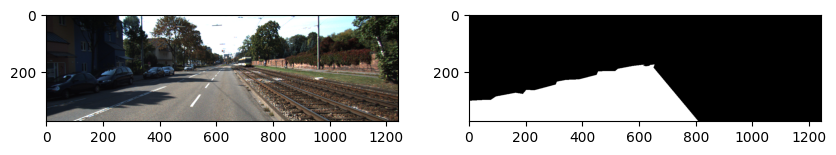

In [31]:
a = [d for d in dataset.take(1)][0]
display_image_segment(a[0], a[1])

In [32]:
dataset = dataset.shuffle(BUFFER_SIZE, seed= SEED)
train_data = dataset.take(TRAIN_SIZE)
val_data = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_data = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

In [33]:
# Create a generator.
rng = tf.random.Generator.from_seed(SEED, alg='philox')

@tf.function
def data_augmentation(img:tf.Tensor, segment:tf.Tensor):
    seed = rng.make_seeds(2)[0]

    img = tf.image.stateless_random_brightness(img, max_delta= 0.5, seed= seed)
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality= 75, max_jpeg_quality= 100, seed= seed)
    
    img = tf.image.stateless_random_flip_left_right(img, seed= seed,)
    segment = tf.image.stateless_random_flip_left_right(segment, seed= seed)

    return img, segment

@tf.function
def resize_and_rescale(img:tf.Tensor, segment:tf.Tensor):
    img = tf.cast(img, tf.float16)
    img = img / 255.0
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    segment = tf.image.resize(segment, (IMG_SIZE, IMG_SIZE))
    return img , segment

@tf.function
def preprocess(ds:tf.data.Dataset, augment=False)->tf.data.Dataset:
    ds = ds.map(resize_and_rescale, num_parallel_calls= AUTOTUNE)
    if augment:
        ds = ds.map(data_augmentation, num_parallel_calls= AUTOTUNE)
        ds = ds.shuffle(BUFFER_SIZE, seed=SEED)
    return ds

In [34]:
# Set up data
train_data = train_data.repeat(3)
train_data = preprocess(train_data, True)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(AUTOTUNE)

val_data = preprocess(val_data)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(AUTOTUNE)

test_data = preprocess(test_data)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTOTUNE)

In [35]:
def display_result_image(img, segment):
    zero_array = np.zeros_like(segment)
    segment_img = np.dstack((zero_array, segment, zero_array)) # Green
    result_img = cv2.addWeighted(src1= img, alpha= 1.0, src2= segment_img, beta= 0.5, gamma= 0)
    plt.imshow(result_img)
    plt.show()

In [36]:
inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
base_model = VGG16(include_top=False, weights="imagenet", input_tensor= inputs)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
def upsample_block(block_input, block_counterpart, channel):
    # Upsampling block
    uppool = layers.Conv2DTranspose(channel, kernel_size= 2, strides= 2)(block_input)
    concat = layers.Add()([uppool, block_counterpart])
    conv = layers.Conv2D(filters=channel, kernel_size=1, activation= 'sigmoid')(concat)
    return conv

In [38]:
# Unet
base_model.trainable = False

b1_pool = base_model.get_layer("block1_pool").output
b2_pool = base_model.get_layer("block2_pool").output
b3_pool = base_model.get_layer("block3_pool").output
b4_pool = base_model.get_layer("block4_pool").output
b5_pool = base_model.get_layer("block5_pool").output

u5 = upsample_block(b5_pool, b4_pool, 512)
u4 = upsample_block(u5, b3_pool, 256)
u3 = upsample_block(u4, b2_pool, 128)
u2 = upsample_block(u3, b1_pool, 64)

u1 = layers.Conv2DTranspose(N_CLASSES, kernel_size= 2, strides= 2)(u2)
outputs = layers.Conv2D(N_CLASSES, 1, activation= 'sigmoid')(u1)

In [39]:
model = Model(inputs, outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath= "Model road segment", save_best_only= True),
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta= 1e-4, patience= 5)
]

model.compile(
    optimizer= keras.optimizers.Adam(),
    loss= keras.losses.BinaryCrossentropy(),
    metrics= keras.metrics.BinaryAccuracy(),
)

In [42]:
model.fit(
    train_data,
    epochs= 200,
    validation_data= val_data,
    callbacks= callbacks
)

Epoch 1/200
173/174 [============================>.] - ETA: 0s - loss: 0.4885 - binary_accuracy: 0.8119

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 20s 81ms/step - loss: 0.4885 - binary_accuracy: 0.8119 - val_loss: 0.4691 - val_binary_accuracy: 0.8146
Epoch 2/200
173/174 [============================>.] - ETA: 0s - loss: 0.3042 - binary_accuracy: 0.8696

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 79ms/step - loss: 0.3040 - binary_accuracy: 0.8697 - val_loss: 0.1511 - val_binary_accuracy: 0.9470
Epoch 3/200
173/174 [============================>.] - ETA: 0s - loss: 0.1366 - binary_accuracy: 0.9453

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 19s 83ms/step - loss: 0.1367 - binary_accuracy: 0.9453 - val_loss: 0.1118 - val_binary_accuracy: 0.9506
Epoch 4/200
173/174 [============================>.] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9527

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 78ms/step - loss: 0.1135 - binary_accuracy: 0.9525 - val_loss: 0.0992 - val_binary_accuracy: 0.9565
Epoch 5/200
173/174 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9559

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 79ms/step - loss: 0.1030 - binary_accuracy: 0.9559 - val_loss: 0.0768 - val_binary_accuracy: 0.9668
Epoch 6/200
173/174 [============================>.] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9614

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 79ms/step - loss: 0.0902 - binary_accuracy: 0.9614 - val_loss: 0.0678 - val_binary_accuracy: 0.9725
Epoch 7/200
173/174 [============================>.] - ETA: 0s - loss: 0.0826 - binary_accuracy: 0.9642

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 79ms/step - loss: 0.0825 - binary_accuracy: 0.9642 - val_loss: 0.0655 - val_binary_accuracy: 0.9728
Epoch 8/200
174/174 [==============================] - 15s 62ms/step - loss: 0.0775 - binary_accuracy: 0.9667 - val_loss: 0.0708 - val_binary_accuracy: 0.9687
Epoch 9/200
173/174 [============================>.] - ETA: 0s - loss: 0.0696 - binary_accuracy: 0.9697

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 19s 81ms/step - loss: 0.0696 - binary_accuracy: 0.9697 - val_loss: 0.0484 - val_binary_accuracy: 0.9786
Epoch 10/200
173/174 [============================>.] - ETA: 0s - loss: 0.0661 - binary_accuracy: 0.9712

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 19s 81ms/step - loss: 0.0661 - binary_accuracy: 0.9712 - val_loss: 0.0439 - val_binary_accuracy: 0.9808
Epoch 11/200
174/174 [==============================] - 16s 63ms/step - loss: 0.0637 - binary_accuracy: 0.9721 - val_loss: 0.0626 - val_binary_accuracy: 0.9724
Epoch 12/200
173/174 [============================>.] - ETA: 0s - loss: 0.0614 - binary_accuracy: 0.9732

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 18s 79ms/step - loss: 0.0614 - binary_accuracy: 0.9733 - val_loss: 0.0420 - val_binary_accuracy: 0.9810
Epoch 13/200
173/174 [============================>.] - ETA: 0s - loss: 0.0563 - binary_accuracy: 0.9753

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 19s 81ms/step - loss: 0.0562 - binary_accuracy: 0.9753 - val_loss: 0.0345 - val_binary_accuracy: 0.9841
Epoch 14/200
174/174 [==============================] - 15s 63ms/step - loss: 0.0550 - binary_accuracy: 0.9759 - val_loss: 0.0345 - val_binary_accuracy: 0.9843
Epoch 15/200
173/174 [============================>.] - ETA: 0s - loss: 0.0547 - binary_accuracy: 0.9758

INFO:tensorflow:Assets written to: Model road segment\assets


INFO:tensorflow:Assets written to: Model road segment\assets


174/174 [==============================] - 19s 80ms/step - loss: 0.0547 - binary_accuracy: 0.9758 - val_loss: 0.0283 - val_binary_accuracy: 0.9862
Epoch 16/200
174/174 [==============================] - 15s 63ms/step - loss: 0.0481 - binary_accuracy: 0.9782 - val_loss: 0.0329 - val_binary_accuracy: 0.9853
Epoch 17/200
174/174 [==============================] - 16s 63ms/step - loss: 0.0478 - binary_accuracy: 0.9783 - val_loss: 0.0377 - val_binary_accuracy: 0.9817
Epoch 18/200
174/174 [==============================] - 16s 63ms/step - loss: 0.0477 - binary_accuracy: 0.9782 - val_loss: 0.0306 - val_binary_accuracy: 0.9855
Epoch 19/200
174/174 [==============================] - 15s 63ms/step - loss: 0.0446 - binary_accuracy: 0.9798 - val_loss: 0.0306 - val_binary_accuracy: 0.9853
Epoch 20/200
174/174 [==============================] - 16s 63ms/step - loss: 0.0427 - binary_accuracy: 0.9805 - val_loss: 0.0305 - val_binary_accuracy: 0.9861


In [44]:
model.evaluate(test_data)

7/7 [==============================] - 2s 46ms/step - loss: 0.0282 - binary_accuracy: 0.9860


[0.028247222304344177, 0.9859736561775208]

In [1]:
test = data[2]
img_test, mask_test = read_img(test)
img_test, mask_test = resize_and_rescale(img_test, mask_test)
mask_pred = model.predict(tf.expand_dims(img_test,0))[0]>0.5
img_test = img_test.numpy()
mask_test = mask_test.numpy()
mask_pred = np.array(mask_pred).astype(np.float32)
display_result_image(img_test, mask_pred)

NameError: name 'data' is not defined

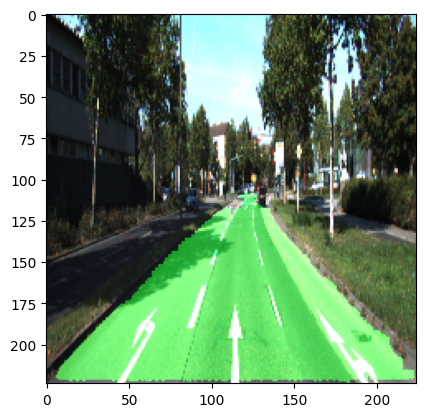

In [94]:
from skimage.morphology import remove_small_objects

mask_pred_1 = (mask_pred.astype(np.bool8)).reshape((IMG_SIZE, IMG_SIZE))
mask_pred_1 = remove_small_objects(mask_pred_1, 100)
mask_pred_1 = (mask_pred_1.astype(np.float32)).reshape((IMG_SIZE, IMG_SIZE, 1))

mask_pred_1 = (mask_pred_1.astype(np.bool8)).reshape((IMG_SIZE, IMG_SIZE))
mask_pred_1 = mask_pred_1 == 0
mask_pred_1 = remove_small_objects(mask_pred_1, 100)
mask_pred_1 = mask_pred_1 == 0
mask_pred_1 = (mask_pred_1.astype(np.float32)).reshape((IMG_SIZE, IMG_SIZE, 1))
display_result_image(img_test, mask_pred_1)

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model("Model road segment")
tflite_model = converter.convert()
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
